In [1]:
from pathlib import Path

import earthkit.data
import earthkit.plots
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from numcodecs.astype import AsType
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_fixed_offset_scale import FixedOffsetScale
from numcodecs_wasm_jpeg2000 import Jpeg2000
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_round import Round

In [2]:
t2m = xr.open_dataset(
    Path() / ".." / "bench" / "era5_t2m_2012_12_01_14:00.nc",
    engine="netcdf4",
).t2m

# convert from K to degC
with xr.set_options(keep_attrs=True):
    t2m = t2m - 273.15
t2m.attrs["units"] = t2m.attrs["GRIB_units"] = "degC"

t2m

<xarray.DataArray 't2m' (valid_time: 1, latitude: 721, longitude: 1440)> Size: 4MB
array([[[-12.350586, -12.350586, -12.350586, ..., -12.350586,
         -12.350586, -12.350586],
        [-12.532227, -12.530273, -12.52832 , ..., -12.540039,
         -12.538086, -12.53418 ],
        [-12.850586, -12.844727, -12.838867, ..., -12.868164,
         -12.864258, -12.858398],
        ...,
        [-26.989258, -26.987305, -26.987305, ..., -26.993164,
         -26.99121 , -26.99121 ],
        [-27.188477, -27.188477, -27.186523, ..., -27.19043 ,
         -27.19043 , -27.188477],
        [-27.637695, -27.637695, -27.637695, ..., -27.637695,
         -27.637695, -27.637695]]], shape=(1, 721, 1440), dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2012-12-01T14:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               degC
    long_name:                                2 metre temperature
    units:                                    degC
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [3]:
vmin, vmax = int(np.floor(np.amin(t2m))), int(np.ceil(np.amax(t2m)))
vlim = max(abs(vmin), abs(vmax))
vmin, vmax, vlim

(-50, 39, 50)

In [4]:
sz3_abs = Sz3(eb_mode="abs", eb_abs=0.1)

encoded_sz3_abs = sz3_abs.encode(t2m.values)
decoded_sz3_abs = t2m.copy(deep=True, data=sz3_abs.decode(encoded_sz3_abs))

In [5]:
t2m.nbytes / encoded_sz3_abs.nbytes

18.342166631333473

In [6]:
float(np.sqrt(np.mean((t2m - decoded_sz3_abs).values.flatten() ** 2)))

0.04904806241393089

In [7]:
sg_abs = SafeguardsCodec(codec=None, safeguards=[dict(kind="abs", eb_abs=0.1)])

encoded_sg_abs = sg_abs.encode(t2m.values)
decoded_sg_abs = t2m.copy(
    deep=True, data=sg_abs.decode(encoded_sg_abs, out=np.empty_like(t2m.values))
)

In [8]:
t2m.nbytes / len(encoded_sg_abs)

9.179516197481963

In [9]:
float(np.sqrt(np.mean((t2m - decoded_sg_abs).values.flatten() ** 2)))

0.05171780288219452

In [10]:
sg_rel = SafeguardsCodec(codec=None, safeguards=[dict(kind="rel", eb_rel=0.1)])

encoded_sg_rel = sg_rel.encode(t2m.values)
decoded_sg_rel = t2m.copy(
    deep=True, data=sg_rel.decode(encoded_sg_rel, out=np.empty_like(t2m.values))
)

In [11]:
t2m.nbytes / len(encoded_sg_rel)

33.43256667659537

In [12]:
float(np.sqrt(np.mean((t2m - decoded_sg_rel).values.flatten() ** 2)))

1.0454736948013306

In [13]:
sg_rmse = SafeguardsCodec(codec=None, safeguards=[dict(kind="rmse", eb_rmse=0.1)])

encoded_sg_rmse = sg_rmse.encode(t2m.values)
decoded_sg_rmse = t2m.copy(
    deep=True, data=sg_rmse.decode(encoded_sg_rmse, out=np.empty_like(t2m.values))
)

In [14]:
t2m.nbytes / len(encoded_sg_rmse)

9.179516197481963

In [15]:
float(np.sqrt(np.mean((t2m - decoded_sg_rmse).values.flatten() ** 2)))

0.05171780288219452

In [16]:
eb_rmse = 0.1
eb_psnr = 20 * (np.log10(float(np.amax(t2m)) - float(np.amin(t2m))) - np.log10(eb_rmse))
print(eb_psnr)
jpeg2000_rmse = CodecStack(
    FixedOffsetScale(offset=float(np.amin(t2m)), scale=(float(np.amax(t2m)) - float(np.amin(t2m))) / (2**16 - 1)),
    Round(precision=1.0),
    AsType(encode_dtype="uint16", decode_dtype="float32"),
    Jpeg2000(mode="psnr", psnr=eb_psnr)
)

encoded_jpeg2000_rmse = jpeg2000_rmse.encode(t2m.values)
decoded_jpeg2000_rmse = t2m.copy(deep=True, data=jpeg2000_rmse.decode(encoded_jpeg2000_rmse))

58.85585127915475


In [17]:
t2m.nbytes / encoded_jpeg2000_rmse.nbytes

42.77036838690409

In [18]:
float(np.sqrt(np.mean((t2m - decoded_jpeg2000_rmse).values.flatten() ** 2)))

0.10440585762262344

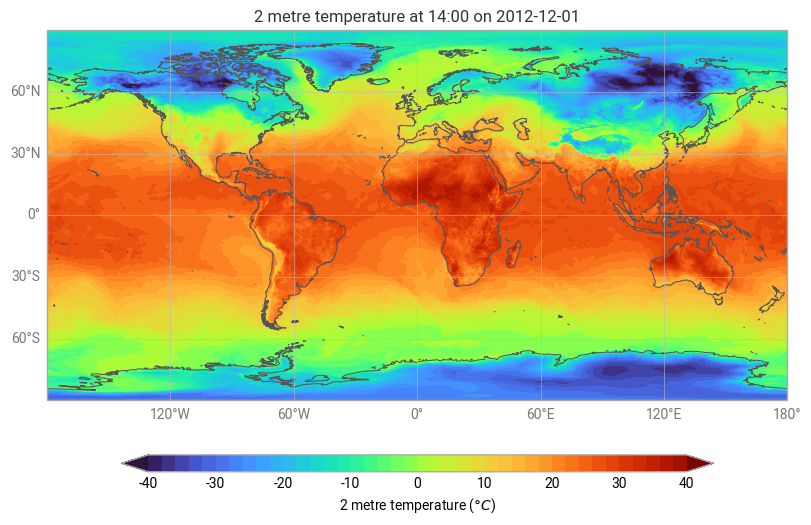

In [19]:
earthkit.plots.quickplot(decoded_jpeg2000_rmse);